# Introduction

In this notebook, we conduct a systematic exploration and preparation of the dataset to ensure its suitability for downstream machine learning tasks. Our workflow includes three major components:

1. **Data Understanding** – We perform an initial inspection of the dataset structure, identify inconsistencies, detect missing or anomalous values, and evaluate variable types and distributions.

2. **Data Cleaning** – We address quality issues by handling missing values, correcting data types, removing or transforming invalid entries, and resolving encoding artifacts. 

3. **Label Construction for Classification Tasks** – We define and generate the target variables needed for our classification tasks, ensuring that labels are accurate, interpretable, and aligned with the clinical objectives of the study.

By the end of this workflow, the dataset will be fully cleaned, well-structured, and ready to be used for training and evaluating machine learning models.


---

### Import Libraries

In [120]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

---

### Data Loading

We load the CSV file using a more explicit configuration to avoid warnings.  
If we used the default settings, Pandas would raise a `DtypeWarning` because it would not correctly infer the date column while reading the file in chunks.  

By disabling chunking (`low_memory=False`) and explicitly parsing the date column (`parse_dates=[7]`), the import becomes slightly slower but much more accurate and stable. Other date columns are converted manually for the same reason.

We also adjust the **display options** to make the initial inspection easier during the analysis.


In [121]:
current_dir = os.getcwd()
main_dir = os.path.abspath(os.path.join(current_dir, "..", ".."))

# Read the CSV with explicit date parsing to avoid dtype warnings
data = pd.read_csv(main_dir +
    '/Datasets/UKDataset/UKdata.csv',
    parse_dates=[7],
    dayfirst=False,
    low_memory=False
)

# Convert additional known date columns using a safe parser
data["Death_date"] = pd.to_datetime(data["Death_date"], errors="coerce")
data["Vdate_0"]    = pd.to_datetime(data["Vdate_0"], errors="coerce")

# Display all columns and increase row visibility for early inspection
pd.options.display.max_columns = None
pd.options.display.max_rows = None

---
---

# Data Understanding

We begin the data understanding phase by inspecting the dataset structure. This gives us an initial overview of the dataset and helps identify potential inconsistencies (e.g., columns parsed as `object` instead of numeric).

We also check whether the dataset contains duplicated entries. As we can see, this doesn't occur.


In [122]:
print("Shape:", data.shape)
print()

print("Data info:")
data.info()
print()

print("Data types:")
print(data.dtypes.value_counts())

print("\n=== Object columns ===")
object_cols = data.select_dtypes(include="object").columns
print(list(object_cols))

print("\n=== Datetime columns ===")
datetime_cols = data.select_dtypes(include="datetime").columns
print(list(datetime_cols))


print()
duplicate_count = data.duplicated().sum()
print("Number of duplicated rows:", duplicate_count)


Shape: (502412, 293)

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502412 entries, 0 to 502411
Columns: 293 entries, Sex to Familiarity_siblings__Prostate_cancer__0
dtypes: datetime64[ns](3), float64(165), int64(124), object(1)
memory usage: 1.1+ GB

Data types:
float64           165
int64             124
datetime64[ns]      3
object              1
Name: count, dtype: int64

=== Object columns ===
['Cause_of_death']

=== Datetime columns ===
['Vdate_0', 'Lost_FU', 'Death_date']

Number of duplicated rows: 0


---

### Columns Overview

In this section, we perform a general assessment of all dataset columns to better understand their structure and suitability for further analysis.  

We start verifying whether any columns contain only a single unique value. We find that **two columns exhibit no meaningful variability**, containing either a single recorded value or almost exclusively missing data:

- **`Urine_microalb_flag_0`** — this flag variable contains only the value *1.0* (indicating microalbumin below the detection limit) together with many missing entries.  
- **`Med_cbd_2_0`** — this medication-related field is almost entirely missing, with only a small number of entries equal to *3.0*.


In [123]:
# Find constant columns
constant_cols = data.columns[data.nunique() == 1]

print("Constant columns found:\n")
for col in constant_cols:
    print(f"- {col}")

print("\nDetails for constant columns:\n")

for col in constant_cols:
    print(f"Column: {col}")
    print("Value counts:")
    print(data[col].value_counts(dropna=False))
    print("NaN count:", data[col].isna().sum())
    print("-" * 40)



Constant columns found:

- Urine_microalb_flag_0
- Med_cbd_2_0

Details for constant columns:

Column: Urine_microalb_flag_0
Value counts:
Urine_microalb_flag_0
1.0    331328
NaN    171084
Name: count, dtype: int64
NaN count: 171084
----------------------------------------
Column: Med_cbd_2_0
Value counts:
Med_cbd_2_0
NaN    500491
3.0      1921
Name: count, dtype: int64
NaN count: 500491
----------------------------------------


We examine the proportion of missing values across all columns in the dataset. We compute both the absolute number of missing entries and their percentage relative to the total number of records. To focus on variables with substantial missingness, we filter and display only the columns where more than **10%** of the values are missing. 

In [124]:
# Missing values summary (ranked + percentage)
missing_df = (
    data.isna()
        .sum()
        .to_frame(name="missing_count")
        .assign(missing_pct=lambda x: x["missing_count"] / len(data) * 100)
        .sort_values("missing_count", ascending=False)
)

threshold = 10
filtered_missing_df = missing_df[missing_df["missing_pct"] > threshold]

# Horizontal display
filtered_missing_df.T


,Months_from_first_malnutrition_DM,Arm_right_impendance_manual_0,Wbody_impedance_manual_0,Arm_left_impendance_manual_0,Leg_right_impendance_manual_0,Leg_left_impendance_manual_0,Med_cbde_3_0,Months_from_first_hypertension_pregnancy,PWV_manual_0,Months_from_first_secondary_hypertension,Months_from_first_other_DM,Months_from_first_yes_proteinuria_hypertension_pregnancy,Months_from_first_DM_pregnancy,Months_from_first_no_proteinuria_hypertension_pregnancy,Lost_FU,Med_cbd_2_0,Med_cbde_2_0,Quality_IMT_210,Quality_IMT_150,Quality_IMT_120,Quality_IMT_240,Months_from_first_unspecified_hypertension_pregnancy,Months_from_first_IDDM,Height_s_3.1,Weight_manual_0,ml4h_reg_lvm,inline_vf_lvm,inline_vf_lvmi,ml4h_seg_lvmi,ml4h_seg_lvm,ml4h_reg_lvmi,Height_s_1.1,Med_cbde_1_0,T2D_age_diagnosis_0,Months_from_first_unspecified_DM,Med_cbd_1_0,Cause_of_death,Death_date,Age_Death,Time_to_death,Age_start_smoke_0,DBP_manual_0,SBP_manual_0,Pulse_rate_manual_0,Months_from_first_NIDDM,Immigration_year_0,Height_s_2.1,Water_intake_0,Phis_act_mod_time_0,Phis_act_light_time_0,Phis_act_vig_time_0,Coffee_0,Alcohol_cat_0,Pack_years_proportion_0,Pack_years_0,Urine_microalb_0,PW_AS_index_0,PW_ptp_0,PW_abnp_0,PR_0,PW_sp_0,PW_pp_0,PW_pn_0,PW_ri_0,Months_from_first_primary_hypertension,Med_cbd_0_0,Med_cbde_0_0,Duration_vigorous_0,Urine_microalb_flag_0,LipoA_0,Above_walking_moderate_vigorous,Above_moderate_vigorous,IPAQ_activity_group,Duration_moderate_0,ApoA_0,Phosphate_0,glucose_0,Total_protein_0,HDL_0,Calcium_0,Albumine_0
missing_count,502405.000000,502387.000000,502387.000000,502387.000000,502387.000000,502387.000000,502319.000000,502282.000000,502251.000000,502114.000000,501867.000000,501835.000000,501632.000000,501576.000000,501114.000000,500491.000000,499998.000000,499834.000000,499834.000000,499834.000000,499834.000000,499569.00000,497231.000000,497171.000000,495061.000000,495006.000000,495006.000000,495006.000000,495006.000000,495006.000000,495006.000000,482099.000000,477818.000000,477134.000000,476876.000000,467990.000000,467497.000000,467376.00000,467376.00000,467376.00000,463181.000000,458618.00000,458618.00000,458618.00000,458608.000000,457872.000000,454309.000000,442330.000000,431721.000000,431721.000000,431721.000000,431721.000000,431721.000000,351494.000000,351494.000000,349540.000000,332651.000000,331794.000000,331698.000000,331698.000000,331698.000000,331698.000000,331698.000000,331698.000000,307605.000000,275514.00000,231613.000000,207734.00000,171084.000000,126846.000000,100218.000000,100106.000000,100106.000000,91448.000000,74977.000000,73236.000000,72920.000000,72883.00000,72616.000000,72555.000000,72412.000000
missing_pct,99.998607,99.995024,99.995024,99.995024,99.995024,99.995024,99.981489,99.974125,99.967955,99.940686,99.891523,99.885154,99.844749,99.833603,99.741646,99.617644,99.519518,99.486875,99.486875,99.486875,99.486875,99.43413,98.968775,98.956832,98.536858,98.525911,98.525911,98.525911,98.525911,98.525911,98.525911,95.956904,95.104814,94.968671,94.917319,93.148651,93.050524,93.02644,93.02644,93.02644,92.191468,91.28325,91.28325,91.28325,91.281259,91.134766,90.425587,88.041289,85.929675,85.929675,85.929675,85.929675,85.929675,69.961307,69.961307,69.572383,66.210799,66.040222,66.021114,66.021114,66.021114,66.021114,66.021114,66.021114,61.225647,54.83826,46.100213,41.34734,34.052531,25.247407,19.947374,19.925081,19.925081,18.201795,14.923409,14.576881,14.513985,14.50662,14.453476,14.441335,14.412872


We distinguish numeric columns that behave as **binary variables** (i.e., columns containing exactly two distinct values) from those that have a broader numeric range.

The first code block counts how many numeric columns are binary and how many are not.  
The second block performs a range analysis **only** on the non-binary numeric columns to avoid meaningless min/max summaries for true binary variables.


In [125]:
# Select numeric columns
num_data = data.select_dtypes(include="number")

# Count distinct values per numeric column
unique_counts = num_data.nunique()

# Binary = exactly two unique values
binary_cols = unique_counts[unique_counts == 2].index

# Non-binary = more than two unique values
non_binary_cols = unique_counts[unique_counts > 2].index

print("Number of binary numeric columns:", len(binary_cols))
print("Number of non-binary numeric columns:", len(non_binary_cols))


Number of binary numeric columns: 132
Number of non-binary numeric columns: 155


In [126]:
num_data_non_binary = num_data[non_binary_cols]

num_data_non_binary.agg(["min", "max"])


,WC_0,HC_0,Height_S_0,Height_s_0,Vmonth_0,Walks_duration_0,Duration_moderate_0,Duration_vigorous_0,Sleep_0,Smoke_t_c_0,Smoke_t_p_0,Alcohol_i_f_0,Weight_manual_0,Age_start_smoke_0,Immigration_year_0,PR_0,PW_ri_0,PW_ptp_0,PW_pp_0,PW_pn_0,PW_sp_0,PWV_manual_0,Wbody_impedance_manual_0,Leg_right_impendance_manual_0,Leg_left_impendance_manual_0,Arm_right_impendance_manual_0,Arm_left_impendance_manual_0,Height_s_0.1,Height_s_1.1,Height_s_2.1,Height_s_3.1,Smoking_status_0,Alcohol_status_0,Pack_years_0,Pack_years_proportion_0,BMI_0,Weight_0,Age_visit_0,PW_AS_index_0,IPAQ_activity_group,Whole_body_fat_perc_0,Whole_body_fat_mass_0,Whole_body_fatfree_0,Whole_body_water_0,Whole_body_impedance_0,Leg_right_impedance_0,Leg_left_impedance_0,Arm_right_impedance_0,Arm_left_impedance_0,Leg_right_fat_perc_0,Leg_right_fat_mass_0,Leg_right_fatfree_0,Leg_right_predictedmass_0,Leg_left_fat_perc_0,Leg_left_fat_mass_0,Leg_left_fatfree_0,Leg_left_predictedmass_0,Arm_right_fat_perc_0,Arm_right_fat_mass_0,Arm_right_fatfree_0,Arm_right_predictedmass_0,Arm_left_fat_perc_0,Arm_left_fat_mass_0,Arm_left_fatfree_0,Arm_left_predictedmass_0,Trunk_fat_perc_0,Trunk_fat_mass_0,Trunk_fatfree_0,Trunk_predictedmass_0,WB_count_0,RBC_0,Hb_0,Hct_0,RBDW_0,PLT_0,Lymph_0,Monocyte_0,Neutroph_0,Eos_0,Basoph_0,N_RBC_0,Lymph_perc_0,Monocyte_perc_0,Neutroph_perc_0,Eos_perc_0,Basoph_perc_0,N_RBC_perc_0,Retic_perc_0,Retic_count_0,Urine_microalb_0,Creat_urine_0,K_urine_0,Na_urine_0,Albumine_0,ALP_0,ALT_0,ApoA_0,ApoB_0,AST_0,Urea_0,Calcium_0,Chol_0,Crea_0,CRP_0,CysC_0,glucose_0,HBA1c_0,HDL_0,LDL_0,LipoA_0,Phosphate_0,Total_protein_0,TG_0,Urate_0,Water_intake_0,Phis_act_vig_time_0,Phis_act_mod_time_0,Phis_act_light_time_0,inline_vf_lvm,inline_vf_lvmi,ml4h_reg_lvm,ml4h_reg_lvmi,ml4h_seg_lvm,ml4h_seg_lvmi,Elapsed_time_visit0_death0,Medicat_n_0,T2D_diagnosis_0,Taking_other_prescr_medicat_0,T2D_age_diagnosis_0,Med_cbde_0_0,Med_cbde_1_0,Med_cbde_2_0,Med_cbd_0_0,Age_Death,Follow_up_time,Time_to_death,SBP_manual_0,SBP_auto_0,DBP_auto_0,DBP_manual_0,Pulse_rate_Auto_manual_0,Pulse_rate_manual_0,Time_BP_measure_manual_0,Months_from_first_IDDM,Months_from_first_NIDDM,Months_from_first_malnutrition_DM,Months_from_first_other_DM,Months_from_first_unspecified_DM,Months_from_first_primary_hypertension,Months_from_first_secondary_hypertension,Months_from_first_hypertension_pregnancy,Months_from_first_no_proteinuria_hypertension_pregnancy,Months_from_first_yes_proteinuria_hypertension_pregnancy,Months_from_first_unspecified_hypertension_pregnancy,Months_from_first_DM_pregnancy
min,20.0,30.0,75.0,70.0,1,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,30.0,-3.0,-3.0,33.0,-4813.0,0.0,3.0,17.0,2.0,3.45,1.0,1.0,1.0,1.0,1.0,20.0,20.0,54.8,66.0,-3.0,-3.0,0.0,0.0,12.1212,30.0,37,0.972739,0.0,5.0,5.0,18.7,18.9,51.0,99.0,99.0,56.0,58.0,1.0,0.1,1.8,2.2,1.5,0.1,0.7,2.2,1.1,0.1,0.7,0.9,1.0,0.1,0.9,0.8,2.0,0.5,2.0,2.0,0.0,0.006,0.09,0.05,2.28,0.3,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,6.7,88.0,2.4,10.0,17.38,8.0,3.01,0.419,0.4,3.3,0.81,1.050,0.601,10.7,0.08,0.295,0.995,15.0,0.219,0.266,3.8,0.369,36.27,0.231,89.1,1.0,0.0,0.0,0.0,-69.535035,-33.931140,54.673523,28.432864,-21.600068,-12.374296,-40452,0.0,-3.0,-3.0,-3.0,-7.0,2.0,3.0,-7.0,40.3,0,4.0,78.0,65.0,32.0,40.0,30.5,22.0,14.0,-182.0,-185.0,-129.0,-176.0,-181.0,-186.0,-169.0,-111.0,-98.0,-98.0,-101.0,-105.0
max,197.0,195.0,209.0,174.0,12,1440.0,1440.0,1440.0,23.0,2.0,4.0,6.0,196.0,69.0,2009.0,192.0,1248.0,1614.0,67.0,94.0,65.0,49.00,887.0,330.0,335.0,473.0,536.0,124.0,112.0,120.0,122.0,2.0,2.0,336.0,7.0,74.6837,197.7,73,530.000000,2.0,69.8,109.8,100.0,84.3,998.0,890.0,731.0,998.0,999.0,74.9,30.6,24.4,23.1,68.2,27.0,24.2,22.9,74.9,19.0,26.0,24.9,74.6,23.1,37.2,32.7,77.6,59.9,58.8,56.5,389.7,7.911,22.27,72.48,38.96,1821.0,196.41,113.39,76.42,9.6,3.03,6.9,98.7,96.9,97.7,100.0,33.8,81.97,90.909,2.433,6746.5,88160.0,200.0,380.7,59.80,1416.7,495.19,2.500,2.0,947.2,41.83,3.611,15.460,1499.3,79.96,7.487,36.813,515.2,4.401,9.797,189.0,4.702,117.36,11.278,1067.

---

### Detecting Unexpected Negative Values in Numeric Columns 

Some columns in this dataset use negative values as *semantic encodings* rather than true numeric measurements.  
For example:
- **–1** = *“Do not know”*  
- **–3** = *“Prefer not to answer”*  

Since these values technically violate the “non-negative” assumption of most clinical numeric fields, we detect which numeric columns contain negative entries.  
This will help us decide later whether to:
- replace them with `NaN`,  
- keep them as categorical codes, or  
- treat them as separate features.


In [127]:
# Count negative values for each numeric column
neg_counts = (num_data < 0).sum()

# Keep only the columns that contain at least one negative value
neg_columns = neg_counts[neg_counts > 0]

print(neg_columns.sort_values(ascending=True))

ml4h_seg_lvm                                                     6
Months_from_first_malnutrition_DM                                6
ml4h_seg_lvmi                                                    6
Months_from_first_hypertension_pregnancy                        17
Months_from_first_yes_proteinuria_hypertension_pregnancy        18
Months_from_first_unspecified_hypertension_pregnancy            25
inline_vf_lvmi                                                  35
inline_vf_lvm                                                   35
Months_from_first_no_proteinuria_hypertension_pregnancy         40
Months_from_first_DM_pregnancy                                  55
PW_ri_0                                                         83
Months_from_first_secondary_hypertension                       157
Smoke_t_c_0                                                    428
Months_from_first_other_DM                                     458
Age_start_smoke_0                                             

---

## Exploring outcome-related columns

We now explore the outcome-related columns in the dataset, which we will later use to define our prediction labels. We will remove these columns from the dataset once the labels have been defined.

Below we provide a brief description of the outcome-related columns we will use to define our prediction labels:

- `Follow_up_time`  
  Represents the follow-up time in **days**. This is the primary column to use when evaluating survival status for participants who **did not die**, since it tells us how long they were observed. If a participant is alive, this is the time window we compare to our survival threshold (e.g., 10 years).

- `Time_to_death`  
  Number of days between the baseline visit and the date of death. It is only defined for individuals who actually died.

- `Lost_FU`  
  The date at which the participant was **lost to follow-up**, meaning they stopped providing information before the end of the study.  
  This can be confused with *Follow_up_time*, but the concepts are different:  
  - *Follow_up_time* is a duration (in days).  
  - *Lost_FU* is a calendar date.  
  
  Participants with a non-null *Lost_FU* left the study early, so their survival time must be interpreted with caution.  
  When both pieces of information are available, **Follow_up_time should be considered the primary and more reliable indicator of follow-up duration**, as it directly expresses the number of observed days and is consistent with how survival thresholds (e.g., 10 years) are evaluated.


- `Death_date`  
  The calendar date of death. 

- `Cause_of_death`  
  Contains the cause of death encoded using **ICD-10 codes**. Since the raw codes are too granular for our analysis, we apply a mapping function that groups them into broader **macro-categories** (e.g., “Cancer”, “Cardiovascular disease”, “Respiratory disease”, etc.).

- `Cause_group`  
  The macro-category derived from the ICD-10 code. This grouped version is more interpretable and more suitable for downstream modeling.

- `Vdate_0`  
  Date of the participant’s **baseline assessment**. 

- `Vmonth_0`  
  The month (as an integer) of the baseline assessment.

- `Elapsed_time_visit0_death0`  
  Derived number of days between the baseline visit and the death date (when applicable). Useful as a consistency check with *Time_to_death*.

- `Age_Death`  
  Age (in years) at the moment of death. Missing for participants who are still alive.

- `label_10`  
  The original label included in the dataset. It indicates whether a participant **died within 10 years**, without distinguishing the cause of death.  
  This label will serve as a reference, but additional outcome definitions may be introduced depending on the study goals.

After generating `Cause_group`, we examine the cardinality of categorical variables and inspect the distribution of the newly created cause-of-death categories.


In [128]:
def icd_group(code):
    """
    Map an ICD-10 cause-of-death code to a broader macro-category.

    Parameters
    ----------
    code : str or NaN
        ICD-10 code describing the specific cause of death.

    Returns
    -------
    str or NaN
        A macro-category describing the general type of cause:
        - "Cancer" for codes starting with 'C'
        - "Cardiovascular disease" for codes starting with 'I'
        - "Respiratory disease" for codes starting with 'J'
        - "Mental/neurological" for codes starting with 'F'
        - "Nervous system" for codes starting with 'G'
        - "COVID-19 / special codes" for codes starting with 'U'
        - "Other" for any other ICD-10 group

    Notes
    -----
    The function uses only the first character of the ICD-10 code,
    since this character indicates the ICD-10 chapter and therefore
    the high-level disease category.
    """

    # If the value is missing, return NaN
    if pd.isna(code):
        return np.nan

    # Extract the first character (ICD-10 chapter)
    c = str(code)[0]

    # Map ICD-10 chapters to macro-categories
    if c == "C":
        return "Cancer"
    if c == "I":
        return "Cardiovascular disease"
    if c == "J":
        return "Respiratory disease"
    if c == "F":
        return "Mental/neurological"
    if c == "G":
        return "Nervous system"
    if c == "U":
        return "COVID-19 / special codes"

    # Default category for all other ICD-10 groups
    return "Other"


In [129]:
# List of outcome-related variables
out_cols = [
    "Follow_up_time", "Time_to_death", "Lost_FU", "Death_date",
    "Cause_of_death", "Vdate_0", "Vmonth_0", "Elapsed_time_visit0_death0",
    "Age_Death", "label_10"
]

# Generate grouped cause-of-death label
data["Cause_group"] = data["Cause_of_death"].apply(icd_group)
out_cols = out_cols + ["Cause_group"]

# Explore categorical cardinalities
cat_data = data.select_dtypes(include="object")
cat_cardinality = cat_data.nunique().sort_values(ascending=False)

print("=== Cardinality of categorical columns ===")
display(cat_cardinality)

print("\n=== Distribution of Cause_group ===")
display(data["Cause_group"].value_counts(dropna=False))

=== Cardinality of categorical columns ===


Cause_of_death    1197
Cause_group          7
dtype: int64


=== Distribution of Cause_group ===


Cause_group
NaN                         467497
Cancer                       17595
Cardiovascular disease        7130
Other                         4003
Respiratory disease           2489
Nervous system                1884
COVID-19 / special codes      1095
Mental/neurological            719
Name: count, dtype: int64

We now inspect the original label provided in the dataset, `label_10`, which indicates whether a participant died within 10 years from baseline.  
In particular, we analyse:

- how many participants fall into each class (0/1),  
- how many entries are missing, and  
- whether the label is consistent with the available follow-up information.

From this inspection, it becomes clear that a `Follow_up_time` equal to **zero** does not indicate the absence of follow-up, but rather that the participant was still under observation when the dataset was constructed and was **not recorded as dead**. In this situation, the participant is effectively treated as **alive beyond the 10-year threshold**, since no death event within 10 years is documented and the censoring time is assumed to occur after the 10-year window.


Conversely, when `Follow_up_time` is **greater than zero**, two situations must be evaluated:

1. **If the participant died**, then `label_10` correctly reflects whether the death occurred within 10 years.  

2. **If the participant is alive**, we must verify whether the follow-up duration (in days) actually exceeds 10 years. If the follow-up period is **shorter than 10 years**, we cannot determine whether the participant survived the entire 10-year window. In such cases, the `label_10` value is considered unreliable and is therefore converted to `NaN`.

This refinement ensures that the 10-year survival label is consistent with the actual temporal information available for each participant.


In [130]:
print("=== Distribution of label_10 ===")
print(data["label_10"].value_counts(dropna=True))

print("\n=== Number of missing values in label_10 ===")
print(data["label_10"].isna().sum())

print("\n=== Distribution of label_10 for participants with non-zero Follow_up_time ===")
nonzero_followup = data.loc[data["Follow_up_time"] != 0, "label_10"]
display(nonzero_followup.value_counts(dropna=False))

print("\n=== Distribution of label_10 for participants with zero Follow_up_time ===")
zero_followup = data.loc[data["Follow_up_time"] == 0, "label_10"]
display(zero_followup.value_counts(dropna=False))


=== Distribution of label_10 ===
label_10
1.0    427406
0.0     34940
Name: count, dtype: int64

=== Number of missing values in label_10 ===
40066

=== Distribution of label_10 for participants with non-zero Follow_up_time ===


label_10
NaN    40066
1.0    20614
0.0     1132
Name: count, dtype: int64


=== Distribution of label_10 for participants with zero Follow_up_time ===


label_10
1.0    406792
0.0     33808
Name: count, dtype: int64

---
---

# Data Cleaning

In this section, we perform the main data cleaning operations, including the handling of constant columns, the correction or removal of negative values, and the treatment of outliers. These steps ensure that the dataset is consistent, interpretable, and suitable for reliable downstream analysis.


## Handle Constant Columns

In the dataset, two columns appear as constant. However, they must be treated differently because only one of them carries meaningful clinical information.

1. `Urine_microalb_flag_0` — a clinically meaningful constant column

    Although `Urine_microalb_flag_0` is constant in its non-null values, it encodes important diagnostic information related to urine microalbumin:

    - **`Urine_microalb_0`**  
    Numerical value of microalbuminuria when it is *measurable*.  
    It is `NaN` when the concentration is below the detection threshold or when the test was not performed.

    - **`Urine_microalb_flag_0`**  
    Binary flag indicating *sub-threshold* (non-detectable) microalbumin levels.  
    By design:  
    - `1` → microalbumin below the detection limit (i.e., absence of microalbuminuria),  
    - `0` → measurable microalbumin value,  
    - `NaN` → test not performed.

    Because these two variables are complementary, we first verify that they do not overlap; that is, no row should have both a non-null measurable value and a non-null flag.  
    If this consistency holds, we then explicitly assign `Urine_microalb_flag_0 = 0` in all rows where `Urine_microalb_0` contains a positive measurable value and the flag is missing.  
    This ensures a coherent and interpretable encoding of microalbumin status.

2. `Med_cbde_2_0` — a constant but non-informative column

    The column `Med_cbde_2_0`, despite being constant like the previous one, does **not** encode meaningful clinical information. Its values do not contribute to the understanding of any medical or behavioural variable, and the column pr

In [131]:
# --- Urine microalbumin handling ---

# Ensure the urine-related columns exist
if {"Urine_microalb_0", "Urine_microalb_flag_0"}.issubset(data.columns):

    # Consistency check: no overlap between non-null value and non-null flag
    mask_value_notna = data["Urine_microalb_0"].notna()
    mask_flag_notna  = data["Urine_microalb_flag_0"].notna()
    overlap_mask     = mask_value_notna & mask_flag_notna

    overlap_count = overlap_mask.sum()
    print("Number of rows with both Urine_microalb_0 and Urine_microalb_flag_0 non-null:",
          overlap_count)

    if overlap_count == 0:
        # Update flag: when a measurable value is present (> 0) and the flag is NaN,
        # we set the flag to 0 (measurable microalbumin, not below detection threshold).
        update_mask = (data["Urine_microalb_0"] > 0) & data["Urine_microalb_flag_0"].isna()
        data.loc[update_mask, "Urine_microalb_flag_0"] = 0

        print("Updated Urine_microalb_flag_0 to 0 for rows with measurable microalbumin.")
    else:
        print("Warning: overlapping non-null values found; urine microalbumin encoding may be inconsistent.")

# --- Drop constant / uninformative column ---

if "Med_cbde_2_0" in data.columns:
    data = data.drop(columns=["Med_cbde_2_0"])
    print()
    print("Dropped column: Med_cbde_2_0 (constant and not informative).")


Number of rows with both Urine_microalb_0 and Urine_microalb_flag_0 non-null: 0
Updated Urine_microalb_flag_0 to 0 for rows with measurable microalbumin.

Dropped column: Med_cbde_2_0 (constant and not informative).


---

## Remove Negative Values



In [101]:
# Select numeric columns
num_data = data.select_dtypes(include="number")

# Count negative values for each numeric column
neg_counts = (num_data < 0).sum()

# Keep only the columns that contain at least one negative value
neg_columns = neg_counts[neg_counts > 0]

# List of numeric columns that contain at least one negative value
neg_cols = neg_columns.index.tolist()

# Subset containing only these columns
num_data_negative = num_data[neg_cols]

# Compute min and max for each column
min_max_df = num_data_negative.agg(["min", "max"]).T

# Compute the number of distinct negative values per column
neg_unique_counts = {
    col: num_data_negative[col][num_data_negative[col] < 0].unique().size
    for col in neg_cols
}

# Compute the total number of distinct values per column (negative + positive)
total_unique_counts = {
    col: num_data_negative[col].nunique()
    for col in neg_cols
}

# Add both metrics as new columns
min_max_df["neg_unique_values"] = min_max_df.index.map(neg_unique_counts)
min_max_df["total_unique_values"] = min_max_df.index.map(total_unique_counts)

# Sort by the lowest minimum value (most negative first)
min_max_df_sorted = min_max_df.sort_values(by="neg_unique_values", ascending=True)

min_max_df_sorted


,min,max,neg_unique_values,total_unique_values
Months_from_first_malnutrition_DM,-129.000000,144.000000,6,7
Months_from_first_yes_proteinuria_hypertension_pregnancy,-98.000000,577.000000,14,266
Months_from_first_hypertension_pregnancy,-111.000000,471.000000,15,111
Months_from_first_unspecified_hypertension_pregnancy,-101.000000,609.000000,20,587
Months_from_first_no_proteinuria_hypertension_pregnancy,-98.000000,572.000000,31,324
inline_vf_lvm,-69.535035,291.873802,35,5087
inline_vf_lvmi,-33.931140,127.575914,35,7406
Months_from_first_DM_pregnancy,-105.000000,1300.000000,38,383
PW_ri_0,-4813.000000,1248.000000,71,509
Months_from_first_secondary_hypertension,-169.000000,616.000000,101,194


In this step, we convert negative values to `NaN` in a set of variables for which negative entries are not clinically meaningful.  
Two distinct groups of variables are affected:

#### **1. Clinical measurement variables where negative values are physiologically impossible**

These variables correspond to anatomical or medication-related measurements.  
Negative values arise from model artefacts, segmentation failures, or questionnaire skip codes, and therefore cannot be interpreted as valid clinical information.
 
- `ml4h_seg_lvm`  
- `ml4h_seg_lvmi`  

For these variables, all negative entries were removed because they do not correspond to real physiological quantities.


#### **2. Questionnaire or behavioural variables where negative values encode missingness or non-response**

In these variables, negative values are not true measurements but categorical codes such as:  
- **–1** → “Do not know”  
- **–3** → “Prefer not to answer”  
- **-7** → “None of the above / Not asked / Questionnaire skip pattern“

Since these codes are semantically equivalent to missing information, they are replaced with `NaN` to avoid incorrect numerical interpretation during modelling.

The affected variables are:

- `Med_cbde_0_0`  
- `Med_cbd_0_0` 
- `Walks_duration_0`  
- `Duration_moderate_0`  
- `Duration_vigorous_0`  
- `Sleep_0`  
- `Smoke_t_c_0`  
- `Smoke_t_p_0`  
- `Alcohol_i_f_0`  
- `Age_start_smoke_0`  
- `Immigration_year_0`  
- `Smoking_status_0`  
- `Alcohol_status_0`  
- `T2D_diagnosis_0`  
- `Taking_other_prescr_medicat_0`  
- `T2D_age_diagnosis_0`  

In all these columns, the distinct negative values consisted exclusively of **–1**, **–3** and/or **-7** confirming that they represent missing or invalid responses rather than interpretable numerical data.

In [100]:
# Columns where negative values are considered invalid and the entire variable should be removed
cols_to_drop = [
    "ml4h_seg_lvm",
    "ml4h_seg_lvmi",
    "Med_cbde_0_0",
    "Med_cbd_0_0",
    "Walks_duration_0",
    "Duration_moderate_0",
    "Duration_vigorous_0",
    "Sleep_0",
    "Smoke_t_c_0",
    "Smoke_t_p_0",
    "Alcohol_i_f_0",
    "Age_start_smoke_0",
    "Immigration_year_0",
    "Smoking_status_0",
    "Alcohol_status_0",
    "T2D_diagnosis_0",
    "Taking_other_prescr_medicat_0",
    "T2D_age_diagnosis_0"
]

# Only drop columns that actually exist in the dataset (safe operation)
cols_to_drop_existing = [col for col in cols_to_drop if col in data.columns]

# Drop the columns
data = data.drop(columns=cols_to_drop_existing)

print("Dropped the following columns:")
for col in cols_to_drop_existing:
    print(f"- {col}")



Dropped the following columns:
- ml4h_seg_lvm
- ml4h_seg_lvmi
- Med_cbde_0_0
- Med_cbd_0_0
- Walks_duration_0
- Duration_moderate_0
- Duration_vigorous_0
- Sleep_0
- Smoke_t_c_0
- Smoke_t_p_0
- Alcohol_i_f_0
- Age_start_smoke_0
- Immigration_year_0
- Smoking_status_0
- Alcohol_status_0
- T2D_diagnosis_0
- Taking_other_prescr_medicat_0
- T2D_age_diagnosis_0


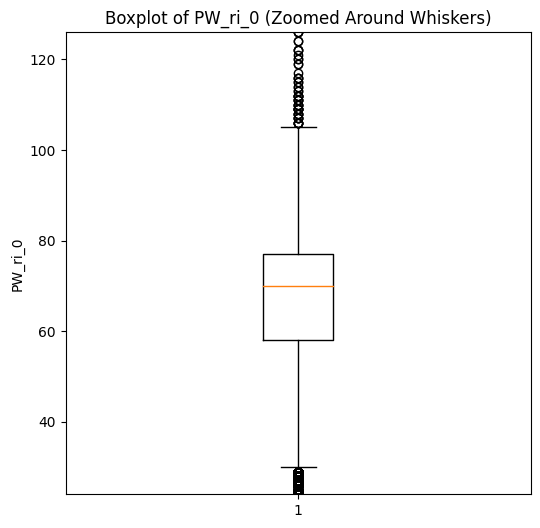

Lower whisker: 30.0
Upper whisker: 105.0


In [103]:
import matplotlib.pyplot as plt
import numpy as np

# Extract PW_ri_0 without missing values
pw = data["PW_ri_0"].dropna()

# Create a temporary boxplot to read whiskers without showing the plot
fig, ax = plt.subplots()
bp = ax.boxplot(pw, vert=True, showfliers=True)
plt.close(fig)

# Extract whiskers (lower/upper non-outlier limits)
whiskers = [item.get_ydata()[1] for item in bp['whiskers']]
lower_w, upper_w = whiskers

# Define zoom window around the whiskers (±20%)
padding = 0.20
ymin = lower_w - abs(lower_w) * padding
ymax = upper_w + abs(upper_w) * padding

# Plot zoomed boxplot
plt.figure(figsize=(6, 6))
plt.boxplot(pw, vert=True, showfliers=True)
plt.ylim(ymin, ymax)
plt.title("Boxplot of PW_ri_0 (Zoomed Around Whiskers)")
plt.ylabel("PW_ri_0")
plt.show()

print("Lower whisker:", lower_w)
print("Upper whisker:", upper_w)


In [105]:
import matplotlib.pyplot as plt

pw = data["PW_ri_0"].dropna()

# Get whiskers from a temporary boxplot
fig, ax = plt.subplots()
bp = ax.boxplot(pw, vert=True, showfliers=True)
plt.close(fig)

lower_w, upper_w = [item.get_ydata()[1] for item in bp['whiskers']]

# Count values within whiskers
within_whiskers = pw[(pw >= lower_w) & (pw <= upper_w)]
num_within = within_whiskers.size

# Count outliers
outliers = pw[(pw < lower_w) | (pw > upper_w)]
num_outliers = outliers.size

print("Lower whisker:", lower_w)
print("Upper whisker:", upper_w)
print("Values within whiskers:", num_within)
print("Values beyond whiskers (outliers):", num_outliers)
print("Total values:", pw.size)


Lower whisker: 30.0
Upper whisker: 105.0
Values within whiskers: 168512
Values beyond whiskers (outliers): 2202
Total values: 170714


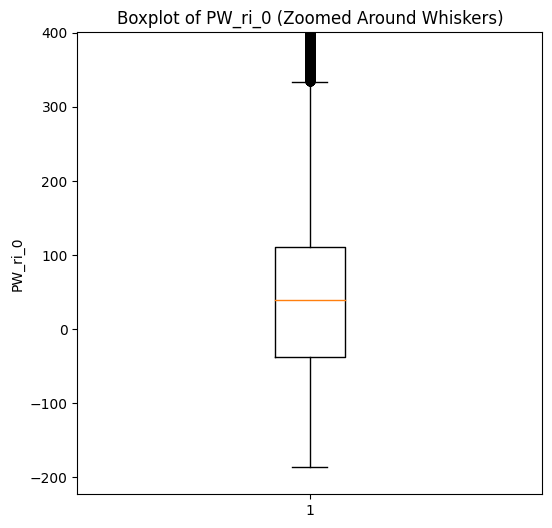

Lower whisker: -186.0
Upper whisker: 334.0


In [104]:
import matplotlib.pyplot as plt
import numpy as np

# Extract PW_ri_0 without missing values
pw = data["Months_from_first_primary_hypertension"].dropna()

# Create a temporary boxplot to read whiskers without showing the plot
fig, ax = plt.subplots()
bp = ax.boxplot(pw, vert=True, showfliers=True)
plt.close(fig)

# Extract whiskers (lower/upper non-outlier limits)
whiskers = [item.get_ydata()[1] for item in bp['whiskers']]
lower_w, upper_w = whiskers

# Define zoom window around the whiskers (±20%)
padding = 0.20
ymin = lower_w - abs(lower_w) * padding
ymax = upper_w + abs(upper_w) * padding

# Plot zoomed boxplot
plt.figure(figsize=(6, 6))
plt.boxplot(pw, vert=True, showfliers=True)
plt.ylim(ymin, ymax)
plt.title("Boxplot of PW_ri_0 (Zoomed Around Whiskers)")
plt.ylabel("PW_ri_0")
plt.show()

print("Lower whisker:", lower_w)
print("Upper whisker:", upper_w)


In [68]:
data.PW_ri_0.value_counts()

PW_ri_0
 75.0      5735
 76.0      5623
 74.0      5565
 73.0      5480
 78.0      5394
 77.0      5371
 72.0      5356
 71.0      5165
 79.0      5154
 70.0      4904
 80.0      4832
 69.0      4821
 68.0      4517
 81.0      4426
 67.0      4314
 66.0      4158
 65.0      3849
 64.0      3707
 82.0      3679
 63.0      3432
 62.0      3416
 83.0      3292
 61.0      3134
 60.0      3015
 59.0      2895
 84.0      2784
 58.0      2702
 57.0      2624
 85.0      2463
 56.0      2446
 55.0      2434
 54.0      2281
 86.0      2158
 53.0      2104
 52.0      2032
 51.0      1891
 87.0      1848
 50.0      1841
 49.0      1817
 48.0      1730
 47.0      1648
 46.0      1587
 45.0      1580
 88.0      1465
 44.0      1437
 43.0      1378
 42.0      1326
 41.0      1281
 89.0      1175
 40.0      1173
 39.0      1132
 90.0       950
 37.0       937
 38.0       930
 36.0       798
 35.0       753
 91.0       663
 34.0       624
 33.0       598
 32.0       485
 92.0       477
 31.0       428


## New Labels Creation

## PCA?

## Qualche plot (magari sui label)

# Exporting the Datasets

In this section, we export all the final datasets produced during the preprocessing pipeline. We provide both:

- **clean, label-free datasets**, suitable for model training and feature engineering, and  
- **label-augmented datasets**, each containing a specific target definition depending on the research question and the classification task of interest.

This separation allows for flexible use of the data in different modelling frameworks and ensures full reproducibility of the preprocessing workflow.


In [12]:
# Base directory where all cleaned datasets will be exported.
base_dir = Path(main_dir) / "Datasets" / "Cleaned_UKDataset"
base_dir.mkdir(exist_ok=True)  # Creates the folder if it does not exist (safe operation)

In [13]:
# Build the final column order:
#   1. binary numeric columns
#   2. continuous/multi-valued numeric columns
#   3. all other columns (categorical, datetime, text...)

num_data = data.select_dtypes(include="number")

unique_counts = num_data.nunique()
binary_cols = unique_counts[unique_counts == 2].index.tolist()
non_binary_cols = unique_counts[unique_counts > 2].index.tolist()

# Other (non-numeric) columns, in original order
other_cols = [
    col for col in data.columns 
    if col not in binary_cols + non_binary_cols
]

ordered_cols = binary_cols + non_binary_cols + other_cols
data = data[ordered_cols]

## Dataset Without Labels

In [15]:
data_without_labels = data.drop(columns=out_cols)

output_path = base_dir / "UKdata_clean_no_labels.csv"
data_without_labels.to_csv(output_path, index=False)

print(f"Dataset without labels saved to: {output_path}")


Dataset without labels saved to: /Users/angelo/Desktop/Code/clinical-data-encoding/Datasets/Cleaned_UKDataset/UKdata_clean_no_labels.csv
